<a href="https://colab.research.google.com/github/dkruit/GenNet-Autoencoder/blob/main/GenNet_Autoencoder_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Import required packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as Kb
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.util.tf_export import keras_export

# Functions to generate dataset and mask

In [2]:
# Create dataset
def generate_dataset(num_patients=100, num_features=100, ld_blocks=10, n_haplotypes=2, 
                     p=0.3, random_seed=23342, shuffle=False, verbose=False):
    print("\nCreating dataset with genotype size", num_features, "and", num_patients, "individuals.")
    np.random.seed(random_seed)
    
    dataset = np.empty([num_patients, num_features])
    dataset[:] = np.nan  # Makes it more clear which values are filled when printing the dataset
    
    # Generate indices where LD-blocks start and finish
    blocks = np.zeros(ld_blocks+1, dtype=int)
    blocks[ld_blocks] = num_features
    blocks[1:ld_blocks] = np.random.choice(range(1, num_features), ld_blocks-1, replace=False)
    blocks = np.sort(blocks)
    if verbose:
        print('LD blocks start/ end at SNP with index ', blocks)
    
    # Fill each block
    for i in range(ld_blocks):
        n_in_block = blocks[i+1] - blocks[i]
        genotypes = []

        # Generate haplotypes for this LD block
        for j in range(n_haplotypes):
            genotypes.append(np.random.binomial(2, p, n_in_block))
        
        # Randomly divide patients in subsets who get the same haplotype
        patient_subsets = np.random.permutation(np.arange(0, num_patients)).reshape(n_haplotypes,num_patients//n_haplotypes)
        
        # Fill dataset
        for j in range(n_haplotypes):
            dataset[patient_subsets[j], blocks[i]:blocks[i+1]] = genotypes[j]
        
        if verbose:
          print('\nDataset after %d out of %d LD blocks are generated:' % (i+1, ld_blocks))
          print(dataset)

    if shuffle:
        dataset = np.random.permutation(dataset.T).T
    
    return dataset

# Small 18x4 dataset to show how the dataset is filled.
_ = generate_dataset(num_features=18, num_patients=4, ld_blocks=3, verbose=True)


Creating dataset with genotype size 18  and  4  individuals.
LD blocks start/ end at SNP with index  [ 0  4 15 18]

Dataset after 1 out of 3 LD blocks are generated:
[[ 0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  2.  0.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  2.  0.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]

Dataset after 2 out of 3 LD blocks are generated:
[[ 0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1. nan nan nan]
 [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0. nan nan nan]
 [ 0.  2.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0. nan nan nan]
 [ 0.  2.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1. nan nan nan]]

Dataset after 3 out of 3 LD blocks are generated:
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 2. 1.]
 [0. 2. 0. 1. 1

The Autoencoder needs a mask to specify which nodes in the input layer (representing SNPs) and the gene layer need to be connected. This mask is stored in a sparse matrix file.

In [3]:
# Generate mask file
def generate_mask(inputsize, output_size):
    mask_d = np.zeros((inputsize, output_size), np.bool)
    start_neuron = np.round(np.linspace(0, inputsize, output_size + 1)).astype(int)
    for i in range(output_size):
        mask_d[start_neuron[i]:start_neuron[i + 1], i] = True
    mask = scipy.sparse.coo_matrix(mask_d)
    return mask


# GenNet Locally-Directed1D layer, AutoEncoder class and AWCC loss function

In [4]:
# Locally-Directed1D layer. The sparse GenNet TensorFlow layer.

@keras_export('keras.layers.LocallyConnected1D')
class LocallyDirected1D(Layer):
    """Locally-Directed1D layer for 1D inputs.
    Dense layer with custom connections. The custom connections are defined by the mask input, a sparse (COO) connectivity matrix.
    # The matrix has the shape of (N_nodes_layer_1, N_nodes_layer_2).
    # It is a sparse matrix with zeros for no connections and ones if there is a connections. For example.
    #             output
    #           1 2 3 4 5
    # input 1 | 1 0 0 0 0 |
    # input 2 | 1 1 0 0 0 |
    # input 3 | 0 1 0 0 0 |
    # input 4 | 0 1 0 0 0 |
    # input 5 | 0 0 1 0 0 |
    # input 6 | 0 0 0 1 0 |
    # input 7 | 0 0 0 1 0 |
    # This connects the first two inputs (1,2) to the first neuron in the second layer.
    # Connects input 2,3 and 4 to output neuron 2.
    # Connects input 5 to output neuron 3
    # Connects input 6 and 7 o the 4th neuron in the subsequent layer
    # Connects nothing to the 5th neuron
    #
    # Writtem for Gennet framework: interpretable neural networks for phenotype prediction
    # (https://www.biorxiv.org/content/10.1101/2020.06.19.159152v1.full)
  Arguments:
      mask: sparse matrix with shape (input, output) connectivity matrix,
            True defines connection between (in_i, out_j), should be sparse (False,0) >> True
            should be scipy sparese matrix in COO Format!
      filters: Integer, the dimensionality of the output space
          (i.e. the number of output filters in the convolution).
      padding: Currently only supports `"valid"` (case-insensitive).
          `"same"` may be supported in the future.
      data_format: A string,
          one of `channels_last` (default) or `channels_first`.
          The ordering of the dimensions in the inputs.
          `channels_last` corresponds to inputs with shape
          `(batch, length, channels)` while `channels_first`
          corresponds to inputs with shape
          `(batch, channels, length)`.
          It defaults to the `image_data_format` value found in your
          Keras config file at `~/.keras/keras.json`.
          If you never set it, then it will be "channels_last".
      activation: Activation function to use.
          If you don't specify anything, no activation is applied
          (ie. "linear" activation: `a(x) = x`).
      use_bias: Boolean, whether the layer uses a bias vector.
      kernel_initializer: Initializer for the `kernel` weights matrix.
      bias_initializer: Initializer for the bias vector.
      kernel_regularizer: Regularizer function applied to
          the `kernel` weights matrix.
      bias_regularizer: Regularizer function applied to the bias vector.
      activity_regularizer: Regularizer function applied to
          the output of the layer (its "activation")..
      kernel_constraint: Constraint function applied to the kernel matrix.
      bias_constraint: Constraint function applied to the bias vector.
  Input shape:
      3D tensor with shape: `(batch_size, steps, input_dim)`
  Output shape:
      3D tensor with shape: `(batch_size, new_steps, filters)`
      `steps` value might have changed due to padding or strides.
  """

    def __init__(self,
                 mask,
                 filters,
                 padding='valid',
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LocallyDirected1D, self).__init__(**kwargs)
        self.filters = filters
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=3)
        self.mask = mask

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            input_dim, input_length = input_shape[1], input_shape[2]
        else:
            input_dim, input_length = input_shape[2], input_shape[1]

        if input_dim is None:
            raise ValueError('Axis 2 of input should be fully-defined. '
                             'Found shape:', input_shape)
        self.output_length = self.mask.shape[1]
        if self.data_format == 'channels_first':
            self.kernel_shape = (input_dim, input_length,
                                 self.filters, self.output_length)
        else:
            self.kernel_shape = (input_length, input_dim,
                                 self.output_length, self.filters)

        self.kernel = self.add_weight(shape=(len(self.mask.data),),  # sum of all nonzero values in mask sum(sum(mask))
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.kernel_idx = sorted(get_idx(self.mask))

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_length, self.filters),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        if self.data_format == 'channels_first':
            self.input_spec = InputSpec(ndim=3, axes={1: input_dim})
        else:
            self.input_spec = InputSpec(ndim=3, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        output = local_conv_matmul_sparse(inputs, self.mask, self.kernel, self.kernel_idx, self.output_length,
                                          self.filters)
        if self.use_bias:
            output = Kb.bias_add(output, self.bias, data_format=self.data_format)

        output = self.activation(output)
        return output

    def get_config(self):
        config = {
            'filters':
                self.filters,
            'padding':
                self.padding,
            'data_format':
                self.data_format,
            'activation':
                activations.serialize(self.activation),
            'use_bias':
                self.use_bias,
            'kernel_initializer':
                initializers.serialize(self.kernel_initializer),
            'bias_initializer':
                initializers.serialize(self.bias_initializer),
            'kernel_regularizer':
                regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer':
                regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint':
                constraints.serialize(self.kernel_constraint),
            'bias_constraint':
                constraints.serialize(self.bias_constraint),
        }
        base_config = super(LocallyDirected1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def local_conv_matmul_sparse(inputs, mask, kernel, kernel_idx, output_length, filters):
    """Apply N-D convolution with un-shared weights using a single matmul call.
  Arguments:
      inputs: (N+2)-D tensor with shape
          `(batch_size, channels_in, d_in1, ..., d_inN)`
          or
          `(batch_size, d_in1, ..., d_inN, channels_in)`.
      mask: sparse matrix COO format connectivity matrix, shape: (input layer, output layer)
      kernel: the unshared weights for N-D convolution,
          an (N+2)-D tensor of shape:
          `(d_in1, ..., d_inN, channels_in, d_out2, ..., d_outN, channels_out)`
          or
          `(channels_in, d_in1, ..., d_inN, channels_out, d_out2, ..., d_outN)`,
          with the ordering of channels and spatial dimensions matching
          that of the input.
          Each entry is the weight between a particular input and
          output location, similarly to a fully-connected weight matrix.
      kernel_idxs:  a list of integer tuples representing indices in a sparse
        matrix performing the un-shared convolution as a matrix-multiply.
      output_length = length of the output.
      output_shape: (mask.shape[1], mask.shape[0]) is used instead.
      filters =  standard 1
  Returns:
      Output (N+2)-D tensor with shape `output_shape` (Defined by the second dimension of the mask).
  """
    output_shape = (mask.shape[1], mask.shape[0])
    inputs_flat = Kb.reshape(inputs, (Kb.shape(inputs)[0], -1))

#     print("kernel_idx", len(kernel_idx))
#     print("inputs", K.shape(inputs_flat))
#     print("kernel", K.shape(kernel))

    output_flat = Kb.sparse_ops.sparse_tensor_dense_mat_mul(
        kernel_idx, kernel, (mask.shape[1], mask.shape[0]), inputs_flat, adjoint_b=True)

    output_flat_transpose = Kb.transpose(output_flat)
    output_reshaped = Kb.reshape(output_flat_transpose, [-1, output_length, filters])
    return output_reshaped


def get_idx(mask):
    """"returns the transposed coordinates in tuple form:
     [(mask.col[0], mask,row[0])...[mask.col[n], mask.row[n])]"""
    coor_list = []
    for i, j in zip(mask.col, mask.row):
        coor_list.append((i, j))

    return coor_list

In [5]:
class Autoencoder(K.models.Model):
    def __init__(self, inputsize, latent_size, masks, latent_connection='lc', kernel_size=-1, activation='tanh'):
        super(Autoencoder, self).__init__()
        self.inputsize = inputsize
        self.latent_size = latent_size
        self.latent_connection = latent_connection
        self.kernel_size = kernel_size
        self.latent_mask = None
        self.latent_mask_T = None
        self.activation = activation

        self.masks = [scipy.sparse.load_npz(m) for m in masks]
        self.masks_T = [m.transpose() for m in self.masks]

        if self.latent_connection == 'lc':
            if len(masks) == 0:
                self.latent_mask = self.make_mask_sparse(self.inputsize, self.latent_size, kernel_size)
            else:
                self.latent_mask = self.make_mask_sparse(self.masks[-1].shape[1], self.latent_size, kernel_size)
            self.latent_mask_T = self.latent_mask.transpose()

        self.init_encoder()
        self.init_decoder()

        print('Model initialized successfully.')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def sample(self, n=1):
        z = np.random.normal(size=(n, self.latent_size))
        decoded = self.decoder(z)
        return decoded

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def init_encoder(self):
        self.encoder = K.Sequential()

        # LocallyDirected1D layer for each mask
        for m in self.masks:
            size = m.shape[0]
            self.encoder.add(K.layers.Reshape(input_shape=(size,), target_shape=(size, 1)))
            self.encoder.add(LocallyDirected1D(mask=m, filters=1, input_shape=(size, 1)))
            self.encoder.add(K.layers.Flatten())
            self.encoder.add(K.layers.Activation(self.activation))
            self.encoder.add(K.layers.BatchNormalization(center=False, scale=False))

        # Code layer
        if self.latent_connection == 'fc':
            self.encoder.add(K.layers.Dense(units=self.latent_size))
        elif self.latent_connection == 'lc':
            size = self.latent_mask.shape[0]
            self.encoder.add(K.layers.Reshape(input_shape=(size,), target_shape=(size, 1)))
            self.encoder.add(LocallyDirected1D(mask=self.latent_mask, filters=1, input_shape=(size, 1)))
            self.encoder.add(K.layers.Flatten())
        else:
            print('Invalid latent_connection argument. Valid values are "fc" for fully connected or "lc" for locally connected.')

    def init_decoder(self):
        self.decoder = K.Sequential()

        # First decoder layer
        if self.latent_connection == 'fc':
            self.decoder.add(K.layers.Dense(units=self.masks[-1].shape[1]))

        elif self.latent_connection == 'lc':
            self.decoder.add(K.layers.Reshape(input_shape=(self.latent_size,), target_shape=(self.latent_size, 1)))
            self.decoder.add(LocallyDirected1D(mask=self.latent_mask_T, filters=1, input_shape=(self.latent_size, 1)))
            self.decoder.add(K.layers.Flatten())

        # Decoder layer for each mask
        for m in reversed(self.masks_T):
            self.decoder.add(K.layers.Activation(self.activation))
            self.decoder.add(K.layers.BatchNormalization(center=False, scale=False))
            self.decoder.add(K.layers.Reshape(input_shape=(m.shape[0],), target_shape=(m.shape[0], 1)))
            self.decoder.add(LocallyDirected1D(mask=m, filters=1, input_shape=(m.shape[0], 1)))
            self.decoder.add(K.layers.Flatten())

        self.add_onehot_output()

    def make_mask_sparse(self, inputsize, latent_size, kernel_size=None):
        """
        Makes a mask so that the genes can be connected to the latent layer in a sparse manner,
        rather than fully connected.
        :param inputsize: Size of input layer for mask
        :param latent_size: Size of output layer for mask
        :param kernel_size: Number of genes connected to one latent neuron. If None: inputsize/latent_size
        :return: returns a mask matrix
        """
        
        mask_d = np.zeros((inputsize, latent_size), np.bool)
        if kernel_size != -1:
            if kernel_size >= inputsize / latent_size:
                start_neuron = np.round(np.linspace(0, inputsize-kernel_size, latent_size)).astype(int)
                for i in range(latent_size):
                    mask_d[start_neuron[i]:start_neuron[i]+kernel_size, i] = True
            else:
                print('Kernel_size should be >= inputsize / latent_size or -1, using default (-1) instead of supplied value.')
                kernel_size = -1

        if kernel_size == -1:
            start_neuron = np.round(np.linspace(0, inputsize, latent_size+1)).astype(int)
            for i in range(latent_size):
                mask_d[start_neuron[i]:start_neuron[i+1], i] = True

        mask = scipy.sparse.coo_matrix(mask_d)

        return mask

    def add_onehot_output(self):
        """
        Adds onehot layer to the decoder so that categorical cross entropy loss can be used.
        """
        row_indices = np.repeat(np.arange(self.inputsize), 3)
        col_indices = np.arange(self.inputsize * 3)
        values = np.ones(self.inputsize * 3, dtype=np.bool)
        mask = scipy.sparse.coo_matrix((values, (row_indices, col_indices)), 
                                      shape=(self.inputsize, 3*self.inputsize), dtype=np.bool)
        
        self.decoder.add(K.layers.Activation(self.activation))
        self.decoder.add(K.layers.BatchNormalization(center=False, scale=False))
        self.decoder.add(K.layers.Reshape(input_shape=(mask.shape[0],), target_shape=(mask.shape[0], 1)))
        self.decoder.add(LocallyDirected1D(mask=mask, filters=1, input_shape=(mask.shape[0], 1)))
        self.decoder.add(K.layers.Flatten())
        self.decoder.add(K.layers.Reshape(input_shape=(3*self.inputsize,), target_shape=(self.inputsize, 3)))


In [6]:
def average_weighted_categorical_crossentropy(frequencies, dtype=K.backend.floatx()):
    """
    A weighted version of keras.objectives.categorical_crossentropy.

    Variables:
        frequencies: List of length 3 cointaining the frequency of class 0, 1 and 2.

    Usage:
        weights = [0.5, 0.2, 0.3] # Class one occurs with a frequency of 0.5, class 2 0.2, class 3 0.3.
        loss = weighted_categorical_crossentropy(frequencies)
        model.compile(loss=loss,optimizer='adam')
    """

    # Normalize label frequencies
    frequencies = np.array(frequencies)
    frequencies /= np.sum(frequencies)

    # Compute and normalize weights
    weights = 1 / frequencies
    weights /= np.dot(frequencies, weights)
    weights = tf.convert_to_tensor(weights, dtype=dtype)

    # SparseCategoricalCrossentropy without weights
    scce = K.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=K.losses.Reduction.NONE)

    def loss(y_true, y_pred):
        loss_ = tf.cast(scce(y_true, y_pred), dtype)

        # Mask to apply the correct weight to each SNP
        mask = tf.cast(tf.math.equal(y_true, 0), dtype) * weights[0] \
               + tf.cast(tf.math.equal(y_true, 1), dtype) * weights[1] \
               + tf.cast(tf.math.equal(y_true, 2), dtype) * weights[2]

        # Apply weights
        loss_ = tf.math.multiply(loss_, mask)

        loss_ = tf.math.reduce_mean(loss_)
        return loss_

    return loss


# Function to plot confusion matrix

In [7]:
def plot_confusion_matrix(actual_labels, predicted_labels, annotation='count'):
    cm = confusion_matrix(actual_labels, predicted_labels).ravel()
    cm = cm.reshape(3, 3)
    if annotation == 'count':
        string_format = 'd'
    elif annotation == 'count_exp':
        string_format = '.2e'
    elif annotation == 'sensitivity':
        string_format = '.3f'
        cm = cm / cm.sum(axis=1)[:, None]
    else:
        print('Invalid annotation type. Default "count" will be used')
        string_format = 'd'

    ax = sns.heatmap(cm, annot=True, fmt=string_format, cmap='viridis')

    # labels, title and ticks
    ax.set_xlabel('PREDICTED LABELS')
    ax.set_ylabel('ACTUAL LABELS')
    ax.set_title('Reconstruction Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1', '2'])
    ax.yaxis.set_ticklabels(['0', '1', '2'])

    return cm, ax


# Train and evaluate model


Creating dataset with genotype size 2000  and  5000  individuals.
Saved mask file.
Model initialized successfully.
Model compiled successfully.
Epoch 1/15
125/125 [==============================] - 6s 31ms/step - loss: 0.8009
Epoch 2/15
125/125 [==============================] - 4s 31ms/step - loss: 0.4916
Epoch 3/15
125/125 [==============================] - 4s 31ms/step - loss: 0.3829
Epoch 4/15
125/125 [==============================] - 4s 32ms/step - loss: 0.3311
Epoch 5/15
125/125 [==============================] - 4s 31ms/step - loss: 0.3035
Epoch 6/15
125/125 [==============================] - 4s 32ms/step - loss: 0.2873
Epoch 7/15
125/125 [==============================] - 4s 31ms/step - loss: 0.2764
Epoch 8/15
125/125 [==============================] - 4s 31ms/step - loss: 0.2694
Epoch 9/15
125/125 [==============================] - 4s 31ms/step - loss: 0.2641
Epoch 10/15
125/125 [==============================] - 4s 31ms/step - loss: 0.2596
Epoch 11/15
125/125 [=============

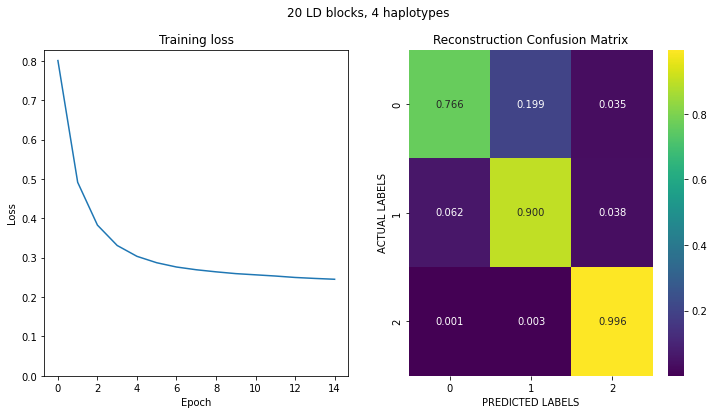

In [8]:
################################################################################
# PARAMETERS
################################################################################

# Parameters for simulated dataset
genotype_size = 2000
ld_blocks = 20
n_haplotypes = 4
p_mutation = 0.2

train_size = 4000
test_size = 1000

# Parameters for the model
n_genes = 100  # Number of nodes in the gene layer
n_latent = 20  # Number of nodes in the latent layer

# Parameters for training the model
epochs = 10
batch_size = 32
learning_rate = 0.005
loss_weights = [(1 - p_mutation)**2,                # frequency of 0 in dataset
                2 * p_mutation * (1-p_mutation),    # frequency of 1 in dataset
                p_mutation**2]                      # frequency of 2 in dataset


################################################################################
# PREPARE DATA AND MODEL
################################################################################
# Dataset
dataset = generate_dataset(num_features=genotype_size, num_patients=train_size+test_size, 
                           ld_blocks=ld_blocks, n_haplotypes=n_haplotypes, p=p_mutation)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

# Generate mask
mask_filename = 'Genemask_' + str(genotype_size) + '.npz'
mask = generate_mask(genotype_size, n_genes)
scipy.sparse.save_npz(mask_filename, mask)
print('Saved mask file.')

# Prepare model for training
ae_model = Autoencoder(inputsize=genotype_size, latent_size=n_latent, 
                       masks=[mask_filename, ])
loss = average_weighted_categorical_crossentropy(loss_weights)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

ae_model.compile(loss=loss, optimizer=optimizer)
print('Model compiled successfully.')


################################################################################
# TRAIN MODEL
################################################################################

history = ae_model.fit(x=train_data, y=train_data,  batch_size=batch_size, epochs=epochs)


################################################################################
# PREDICT RECONSTRUCTION AND PLOT RESULTS
################################################################################
reconstruction = ae_model.predict(x=test_data)
reconstruction = reconstruction.argmax(axis=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('%d LD blocks, %d haplotypes' % (ld_blocks, n_haplotypes))
ax[0].plot(history.epoch, history.history['loss'])
ax[0].set_title('Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_ylim((0, None))

conf, ax[1] = plot_confusion_matrix(test_data.flatten(), reconstruction.flatten(), annotation='sensitivity')

plt.show()